#Image classification via fine-tuning with EfficientNet

EfficientNet, first introduced in Tan and Le, 2019 is among the most efficient models (i.e. requiring least FLOPS for inference) that reaches State-of-the-Art accuracy on both imagenet and common image classification transfer learning tasks.

###Keras implementation of EfficientNet

An implementation of EfficientNet B0 to B7 has been shipped with tf.keras since TF2.3. To use EfficientNetB0 for classifying 1000 classes of images from imagenet, run:



In [ ]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

21834768/21834768 [==============================] - 2s 0us/step


This model takes input images of shape (224, 224, 3), and the input data should range [0, 255]. Normalization is included as part of the model.

In [ ]:
model = EfficientNetB0(include_top=False, weights='imagenet')

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.4)

In [ ]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [ ]:
!pip install cloud-tpu-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: uritemplate
    Found existing installation: uritemplate 4.1.1
    Uninstalling uritemplate-4.1.1:
      Successfully uninstalled uritemplate-4.1.1
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 2.11.0
    Uninstalling google-api-core-2.11.0:
      Successfully uninstalled google-api-core-2.11.0
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.84.0
    Uninstalling google-api-python-client-2.84.0:
      Successfully uninstalled google-api-python-client-2.84.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the followi

In [ ]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy


In [ ]:
!pip install tensorflow-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_datasets as tfds

batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete39GIKS/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete39GIKS/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


When the dataset include images with various size, we need to resize them into a shared size. The Stanford Dogs dataset includes only images at least 200x200 pixels in size. Here we resize the images to the input size needed for EfficientNet.

In [ ]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

###Visualizing the data

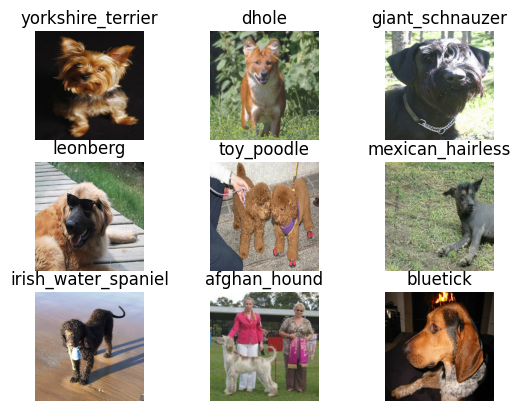

In [ ]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

###Data augmentation

We can use the preprocessing layers APIs for image augmentation.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

This Sequential model object can be used both as a part of the model we later build, and as a function to preprocess data before feeding into the model. Using them as function makes it easy to visualize the augmented images. 

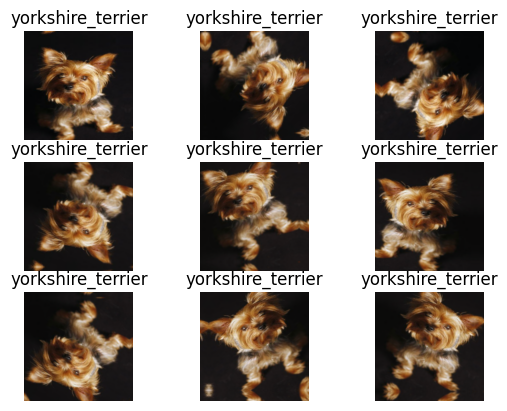

In [ ]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

###Prepare inputs

In [ ]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

###Training a model from scratch

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

epochs = 10  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 img_augmentation (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 120)              4203291   
                                                                 
Total params: 4,203,291
Trainable params: 4,161,268
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/10
187/187 - 183s - loss: 4.9721 - accuracy: 0.0120 - val_loss: 5.0705 - val_accuracy: 0.0133 - 183s/epoch - 978ms/step
Epoch 2/10
187/187 - 134s - loss: 4.6237 - accuracy: 0.0226 - val_loss: 5.0883 - val_accuracy: 0.0157 - 134s/epoch -

Hence training from scratch requires very careful choice of hyperparameters and is difficult to find suitable regularization. It would also be much more demanding in resources. Plotting the training and validation accuracy makes it clear that validation accuracy stagnates at a low value.

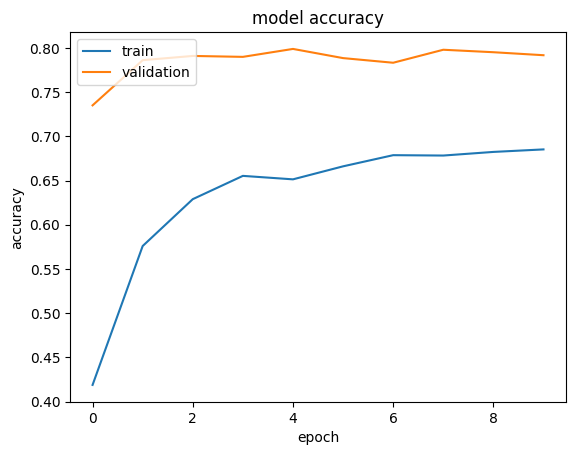

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

###Transfer learning from pre-trained weights

Here we initialize the model with pre-trained ImageNet weights, and we fine-tune it on our own dataset.

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

Epoch 1/10
187/187 - 47s - loss: 3.2601 - accuracy: 0.4169 - val_loss: 0.8608 - val_accuracy: 0.7332 - 47s/epoch - 249ms/step
Epoch 2/10
187/187 - 37s - loss: 1.6416 - accuracy: 0.5892 - val_loss: 0.7051 - val_accuracy: 0.7849 - 37s/epoch - 199ms/step
Epoch 3/10
187/187 - 37s - loss: 1.3421 - accuracy: 0.6249 - val_loss: 0.6837 - val_accuracy: 0.7893 - 37s/epoch - 197ms/step
Epoch 4/10
187/187 - 37s - loss: 1.2136 - accuracy: 0.6534 - val_loss: 0.7057 - val_accuracy: 0.7860 - 37s/epoch - 198ms/step
Epoch 5/10
187/187 - 37s - loss: 1.1836 - accuracy: 0.6656 - val_loss: 0.7039 - val_accuracy: 0.7886 - 37s/epoch - 198ms/step
Epoch 6/10
187/187 - 37s - loss: 1.1744 - accuracy: 0.6591 - val_loss: 0.6448 - val_accuracy: 0.8038 - 37s/epoch - 199ms/step
Epoch 7/10
187/187 - 42s - loss: 1.1394 - accuracy: 0.6733 - val_loss: 0.6737 - val_accuracy: 0.8011 - 42s/epoch - 227ms/step
Epoch 8/10
187/187 - 37s - loss: 1.1188 - accuracy: 0.6737 - val_loss: 0.7113 - val_accuracy: 0.7949 - 37s/epoch - 200

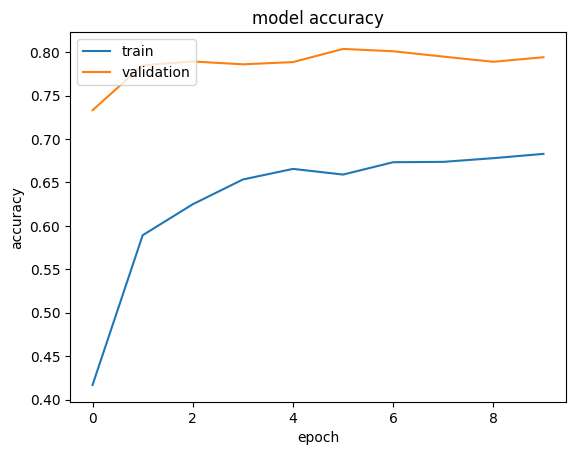

In [ ]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

epochs = 10  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

The second step is to unfreeze a number of layers and fit the model using smaller learning rate. In this example we show unfreezing all layers, but depending on specific dataset it may be desireble to only unfreeze a fraction of all layers.

Epoch 1/10
187/187 - 49s - loss: 0.8783 - accuracy: 0.7485 - val_loss: 0.6174 - val_accuracy: 0.8191 - 49s/epoch - 263ms/step
Epoch 2/10
187/187 - 38s - loss: 0.7445 - accuracy: 0.7704 - val_loss: 0.6241 - val_accuracy: 0.8211 - 38s/epoch - 206ms/step
Epoch 3/10
187/187 - 38s - loss: 0.6729 - accuracy: 0.7950 - val_loss: 0.6087 - val_accuracy: 0.8278 - 38s/epoch - 205ms/step
Epoch 4/10
187/187 - 38s - loss: 0.6353 - accuracy: 0.8050 - val_loss: 0.6155 - val_accuracy: 0.8235 - 38s/epoch - 205ms/step
Epoch 5/10
187/187 - 38s - loss: 0.6015 - accuracy: 0.8101 - val_loss: 0.6210 - val_accuracy: 0.8208 - 38s/epoch - 204ms/step
Epoch 6/10
187/187 - 38s - loss: 0.5560 - accuracy: 0.8260 - val_loss: 0.6299 - val_accuracy: 0.8201 - 38s/epoch - 205ms/step
Epoch 7/10
187/187 - 38s - loss: 0.5308 - accuracy: 0.8335 - val_loss: 0.6309 - val_accuracy: 0.8183 - 38s/epoch - 206ms/step
Epoch 8/10
187/187 - 44s - loss: 0.5007 - accuracy: 0.8427 - val_loss: 0.6193 - val_accuracy: 0.8194 - 44s/epoch - 238

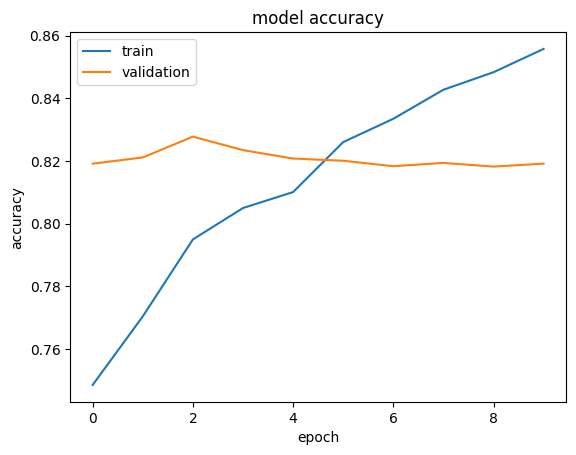

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 10  # @param {type: "slider", min:8, max:50}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)